In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from jupyterthemes import jtplot#设置图片显示格式
jtplot.style(theme = 'monokai')#, grid=False

### 1 读取数据

In [ ]:
data = pd.read_csv('4.kmeans_train.csv', encoding='utf-8',engine='python') #读取数据
#data.head() #查看表格默认前5行

In [ ]:
data.head()

### 2 数据预处理

#### 2.1 数据探索性分析

In [5]:
def explore(data):
    #查看数据分布
    print('-----描述性统计------')
    print(data.describe())
    
    print('------缺失率------')
    #查看数据缺失情况
    list_datanull = [i for i in data.columns if (data[i].isnull().sum())>0]
    for i in list_datanull:
        mis_rate = data[i].isnull().sum()/data.shape[0]
        print(i,'\t',round(mis_rate,4))
        
    ##查看数据是否存在异常极端值
    number_col = [i for i in data.columns if data[i].dtype=='float']
    c=len(number_col)
    k=round(c/4)
    plt.figure(figsize = (4*4,4*k))
    for i,fea in enumerate(number_col):
        plt.subplot(k,4,i+1)  #k行4列展示图片
        sns.boxplot(y=fea,data=data,width=0.4,fliersize=3,whis=3)
        plt.xlabel(' ')

-----描述性统计------
               k          g         c1         c2
count  18.000000  20.000000  19.000000  20.000000
mean    3.777778   4.100000   4.421053   3.450000
std     2.157219   2.023546   2.063325   1.538112
min     1.000000   2.000000   1.000000   1.000000
25%     2.000000   2.000000   3.500000   2.000000
50%     3.000000   3.500000   4.000000   3.000000
75%     5.750000   6.250000   6.000000   5.000000
max     8.000000   7.000000   8.000000   7.000000
------缺失率------
k 	 0.1429
g 	 0.0476
c1 	 0.0952
c2 	 0.0476


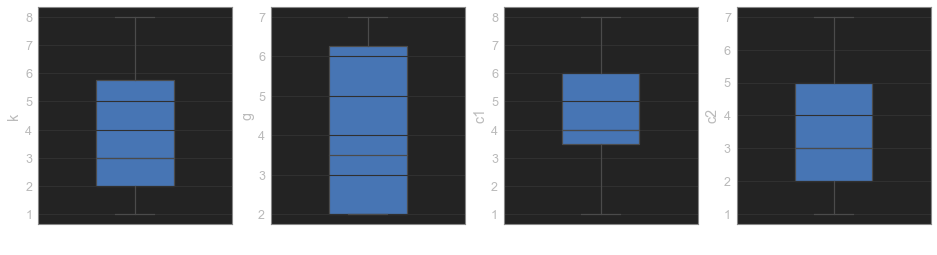

In [6]:
#查看数据分布
explore(data)

#### 2.2 缺失值处理

In [7]:
def null_deal(data):
    #删掉缺失率大于90%的样本
    thresh=data.shape[1]*0.1
    data.dropna(thresh=thresh,axis=0,inplace=True)
    #print(data.shape)
    #缺失列处理
    list_datanull = [i for i in data.columns if (data[i].isnull().sum())>0]
    for i in list_datanull:
        mis_rate = data[i].isnull().sum()/data.shape[0]
        if mis_rate<0.9:
            if data[i].dtypes!='object':
                data[i]=data[i].fillna(data[i].median())
            else:
                data[i]=data[i].fillna('unknow')
        else:
            data.drop(i,axis=1,inplace=True)
        #print(data.shape)
    return data

In [8]:
data=null_deal(data)

#### 2.3 异常值处理

In [9]:
#替换异常值(盖帽法)
def outlier_deal(data):  
    number_col = [i for i in data.columns if data[i].dtype!='object']
    data_c=data.drop(number_col,axis=1)
    data = data[number_col]
    data_des = data.describe()
    des_col=data_des.columns
    for i,col in enumerate(des_col):
        sts= data_des.iloc[:,i]
        shangjie = sts['75%']+4*(sts['75%']-sts['25%'])   #上界
        xiajie = sts['25%']-4*(sts['75%']-sts['25%'])   #上界
        data[col]=np.where(data[col]>shangjie,shangjie,data[col])
        data[col]=np.where(data[col]<xiajie,xiajie,data[col])
    #合并数据
    data = pd.concat([data_c,data],axis = 1,ignore_index = False)
    return data   

In [10]:
data=outlier_deal(data)

#### 2.4 数据标准化处理

In [11]:
#数据量纲不一样，聚类前需要对数据进行标准化处理

#data_zs = 1.0*(data[col] - data[col].mean())/data[col].std() #连续型数据标准化
from sklearn.preprocessing import StandardScaler

def zscore_deal(data):
    col = [i for i in data.columns if data[i].dtype!='object']
    sc =StandardScaler() # 初始化缩放器
    data[col]=sc.fit_transform(data[col]) #对数据进行标准化
    return data

#训练数据标准化
data=zscore_deal(data)

### 3 选取模型最优参数

#### 3.1 利用SSE选择K

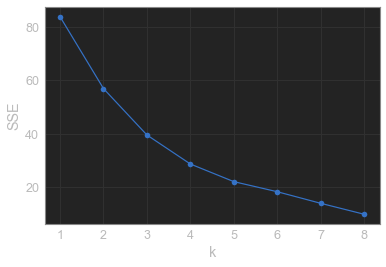

In [12]:
#SSE拐点处的K为最优取值
SSE = []  # 存放每次结果的误差平方和
for k in range(1,9):
    estimator = KMeans(n_clusters=k,init='k-means++', random_state=42)  # 构造聚类器
    estimator.fit(data)
    SSE.append(estimator.inertia_)
X = range(1,9)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X,SSE,'o-')
plt.show()

#### 3.2 利用轮廓系数选择最优K

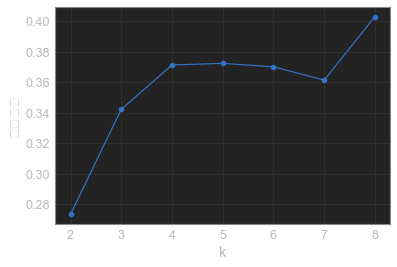

In [13]:
#轮廓系数:s值越接近1表示样本分类越合理,越接近-1,表示样本j应该分类到另外的簇中,近似为0,表示样本应该在边界上;所有样本的s的均值被成为聚类结果的轮廓系数。
#选择轮廓系数最大的K
Scores = []  # 存放轮廓系数
for k in range(2,9):
    estimator = KMeans(n_clusters=k,init='k-means++', random_state=42)  # 构造聚类器
    estimator.fit(data)
    Scores.append(metrics.silhouette_score(data,estimator.labels_,metric='euclidean'))
X = range(2,9)
plt.xlabel('k')
plt.ylabel(u'轮廓系数')
plt.plot(X,Scores,'o-')
plt.show()

### 4 训练最优参数对应的模型

#### 4.1 训练模型

In [14]:
kms=KMeans(n_clusters=4,init='k-means++' , random_state=42)#初始化聚类器 
kms.fit(data)                     #训练聚类模型
label_kms=kms.labels_             #获取聚类标签
print('聚类标签:%s'%label_kms)
center_kms=kms.cluster_centers_    #获取聚类中心
print('聚类中心:%s'%center_kms)
#inertia =kms.inertia_            # 获取聚类准则的总和
#print('SSE：%f'%inertia)
#print('轮廓系数：%f'%metrics.silhouette_score(data, label_kms, metric='euclidean'))

聚类标签:[2 3 2 3 0 3 0 2 3 0 1 1 1 2 1 0 0 1 1 3 1]
聚类中心:[[ 0.27212054  0.58505144  1.36817614  0.52615154]
 [-0.77748725 -0.77760002 -0.57214638  0.48717735]
 [-0.72282018  1.51817147 -0.19900744 -1.14486678]
 [ 1.39461775 -0.71094859 -0.40796525 -0.29230641]]


In [15]:
#每类的聚类中心及其数目
label_count=pd.Series(kms.labels_).value_counts() #获取聚类标签
label_center=pd.DataFrame(kms.cluster_centers_)   #获取聚类中心
data_c=pd.concat([label_center,label_count],axis=1)
data_c.columns=list(label_center)+['类别数目']

In [16]:
data_c

,0,1,2,3,类别数目
0,0.272121,0.585051,1.368176,0.526152,5
1,-0.777487,-0.777600,-0.572146,0.487177,7
2,-0.722820,1.518171,-0.199007,-1.144867,4
3,1.394618,-0.710949,-0.407965,-0.292306,5


In [18]:
#给每个样本打标归类
data_label=pd.concat([data,pd.Series(kms.labels_,index=data.index)],axis=1)
data_label.columns=list(data.columns)+['聚类类别']
# data_label.to_excel('result.csv',index=False)

In [20]:
data_label.head()

,k,g,c1,c2,聚类类别
0,-0.340151,1.518171,-0.199007,-1.656403,2
1,1.190527,-1.073829,-0.199007,1.071790,3
2,-0.850377,1.518171,-0.199007,-0.974355,2
3,2.210979,-0.296229,0.845782,-0.292306,3
4,-0.340151,-0.037029,1.368176,1.071790,0


#### 4.2 保存模型
方便下次调用训练好的模型来预测新的数据

In [22]:
from sklearn.externals import joblib

# 存储训练好的模型
joblib.dump(kms,'cluster.pkl')

['cluster.pkl']

#### 4.3 预测新数据

In [23]:
#读取新数据
test=pd.read_csv('4.kmeans_test.csv',encoding='utf-8',engine='python')

#再次调用训练好的模型
kms = joblib.load('cluster.pkl')

#测试数据处理(对测试数据做同样的预处理工作)
#缺失值处理
test=null_deal(test)
#异常值处理
test=outlier_deal(test)
#标准化处理
test=zscore_deal(test)

#预测新数据
kms.predict(test)

array([2, 1, 2, 3, 0, 3, 0, 0, 1, 1])

In [25]:
test_label=pd.Series(kms.predict(test))
test_labels=pd.concat([test,test_label],axis=1)
test_labels.columns=list(test.columns)+['聚类类别']

In [26]:
test_labels

,k,g,c1,c2,聚类类别
0,0.792406,1.262672,-0.703989,-1.615385,2
1,-0.088045,-1.165543,-0.703989,1.461538,1
2,-1.848947,1.262672,-0.162459,-0.846154,2
3,0.792406,-1.165543,0.379071,-0.076923,3
4,1.672857,-0.194257,0.920602,1.461538,0
5,0.352180,-0.679900,-0.162459,-0.846154,3
6,-0.528271,0.777029,0.920602,0.692308,0
7,0.352180,1.262672,0.920602,-0.846154,0
8,-0.088045,-1.165543,-2.328581,0.692308,1
9,-1.408721,-0.194257,0.920602,-0.076923,1


### 混合数据聚类
若数据只有连续变量用K-means;
若数据只有分裂变量用K-modes;
若数据只有分裂变量用K-prototypes。

In [ ]:
from kmodes.kprototypes import KPrototypes

In [183]:
data1=pd.read_csv('4.kprototypes_train.csv')

In [185]:
data1.head()

,k,g,c1,c2
0,NaN,7.0,4.0,1.0
1,a,2.0,4.0,5.0
2,c,7.0,NaN,2.0
3,b,NaN,6.0,3.0
4,NaN,4.0,7.0,5.0


-----描述性统计------
               g         c1         c2
count  15.000000  14.000000  15.000000
mean    4.333333   4.571429   3.200000
std     2.225395   2.243428   1.373213
min     2.000000   1.000000   1.000000
25%     2.000000   4.000000   2.000000
50%     4.000000   4.000000   3.000000
75%     7.000000   6.750000   4.500000
max     7.000000   8.000000   5.000000
------缺失率------
k 	 0.1875
g 	 0.0625
c1 	 0.125
c2 	 0.0625


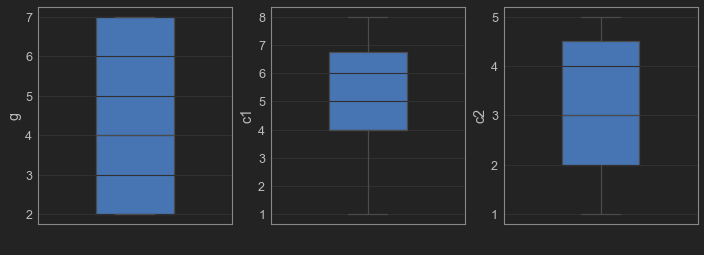

In [186]:
#数据探索性分析
explore(data1)

In [189]:
#缺失值处理
data1=null_deal(data1)
#异常值处理
data1=outlier_deal(data1)

In [190]:
#标准化处理
data1=zscore_deal(data1)

In [191]:
data1

,g,c1,c2
0,1.249100,-0.238366,-1.647720
1,-1.074807,-0.238366,1.365254
2,1.249100,-0.238366,-0.894477
3,-0.145244,0.715097,-0.141233
4,-0.145244,1.191828,1.365254
5,-0.610025,0.238366,-0.894477
6,0.784318,1.191828,0.612010
7,1.249100,-0.238366,-0.894477
8,-1.074807,-1.668560,-0.141233
9,-0.145244,1.191828,-0.141233


In [169]:
kp= KPrototypes(n_clusters=3, init='Cao')
kp=kp.fit(data1, categorical=[0])

In [170]:
kps=kp.predict(data1, categorical=[0])
print(kps)

[1 2 1 0 0 2 0 1 2 0 2 2 2 1 2 0]


In [171]:
# 存储训练好的模型
joblib.dump(kp,'cluster_kp.pkl')

['cluster_kp.pkl']